In [1]:
from collections.abc import Callable, Generator
from pathlib import Path
from typing import Optional, cast

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import xarray as xr
from IPython.display import Image, display

np.random.seed(42)

print(animation.writers.list())

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']


In [2]:
event_days = ["2024-01-13"]

In [3]:
def _handle_expver(ds: xr.Dataset) -> xr.Dataset:
    if "expver" in list(ds.coords.keys()):
        print("expver dimension found, removing it")
        ds_combine = ds.sel(expver=1).combine_first(ds.sel(expver=5))
        ds_combine.load()
        ds = ds_combine
    return ds


def get_uv_wind_components_with_speed(date: str) -> Optional[xr.Dataset]:
    print(f"Getting u10 and v10 wind components for {date}")
    year, month, day = map(int, date.split("-"))

    month_data_path = Path("RJ_2024_1.nc")
    if not month_data_path.exists():
        print(f"File {month_data_path} does not exist")
        return None

    ds = _handle_expver(xr.open_dataset(month_data_path))

    if day not in pd.to_datetime(ds.time.values).day:
        print(f"Day {day} is not in the {month_data_path}")
        return None

    ds_day = ds.sel(time=f"{year}-{month:02d}-{day:02d}")
    ds_day = ds_day[["u10", "v10", "tp"]]
    ds_day["speed10"] = np.sqrt(ds_day["u10"] ** 2 + ds_day["v10"] ** 2)
    print(f"{date} - done")
    return ds_day

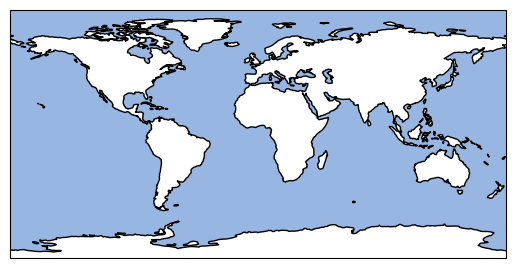

<Figure size 640x480 with 0 Axes>

In [4]:
"""refer:
https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html
https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.mpl.geoaxes.GeoAxes.html
"""
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.show()
plt.clf()

In [5]:
FPS = 5


def _get_variables(ds: xr.Dataset) -> Generator[npt.NDArray, None, None]:
    return (
        ds[var].values for var in ["u10", "v10", "speed10", "tp", "longitude", "latitude", "time"]
    )


def _get_update_fn(ax, quiver, scatter, u10, v10, spd, tp, time) -> Callable:
    def _update_fn(frame):
        quiver.set_UVC(u10[frame], v10[frame], spd[frame])
        ax.set_title(f"Wind on {str(time[frame])}")

        scatter.set_sizes(tp[frame].flatten() * 2000)

        return quiver, scatter

    return _update_fn


def animate_wind_tp_components(ds: xr.Dataset):
    u10, v10, spd, tp, lon, lat, time = _get_variables(ds)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.add_feature(cfeature.STATES.with_scale("10m"))

    quiver = ax.quiver(
        lon,
        lat,
        u10[0],
        v10[0],
        spd[0],
        scale=30,
        cmap="cool",
        transform=ccrs.PlateCarree(),
    )

    scatter = ax.scatter(
        np.tile(lon, lat.size),
        np.repeat(lat, lon.size),
        s=tp[0].flatten() * 2000,
        alpha=0.5,
        edgecolors="blue",
        c="black",
    )

    anim = animation.FuncAnimation(
        fig,
        _get_update_fn(ax, quiver, scatter, u10, v10, spd, tp, time),
        frames=len(time),
        blit=True,
    )
    plt.colorbar(quiver, ax=ax, label="Wind Speed (m/s)", orientation="vertical", pad=0.05)
    ax.set(xlabel="Longitude", ylabel="Latitude")
    return anim


gif_files: list[str] = []
ds_days: list[xr.Dataset] = []
for index, day in enumerate(event_days):
    ds_day = get_uv_wind_components_with_speed(day)
    if ds_day is None:
        continue
    # print(ds_day)
    anim = animate_wind_tp_components(ds_day)
    gif_file = f"gif_{index}_{day}_dale.gif"
    anim.save(gif_file, writer="imagemagick", fps=FPS)
    gif_files.append(gif_file)
    ds_days.append(ds_day)
    plt.clf()

Getting u10 and v10 wind components for 2024-01-13
2024-01-13 - done


<Figure size 1200x600 with 0 Axes>

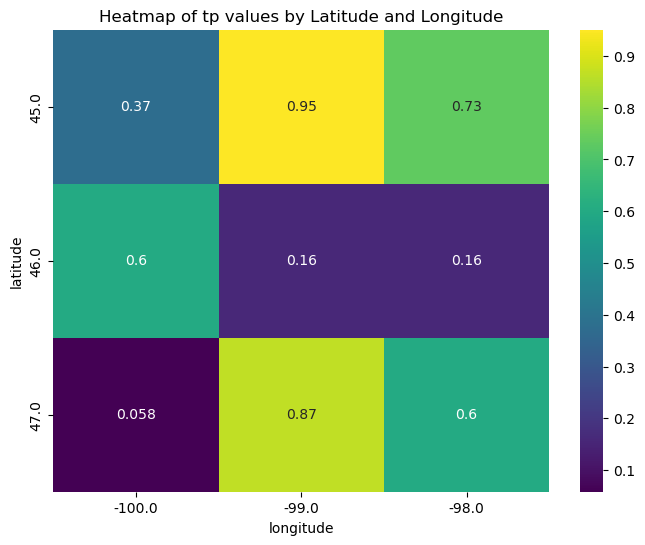

In [6]:
df_toy = pd.DataFrame(
    {
        "tp": np.random.rand(9),
        "latitude": np.repeat([45.0, 46.0, 47.0], 3),
        "longitude": np.tile([-100.0, -99.0, -98.0], 3),
    }
)

df_toy = df_toy.set_index(["latitude", "longitude"])
df_unstacked = df_toy.unstack(level="longitude")
plt.figure(figsize=(8, 6))
sns.heatmap(df_unstacked["tp"], annot=True, cmap="viridis", cbar=True)
plt.title("Heatmap of tp values by Latitude and Longitude")
plt.show()

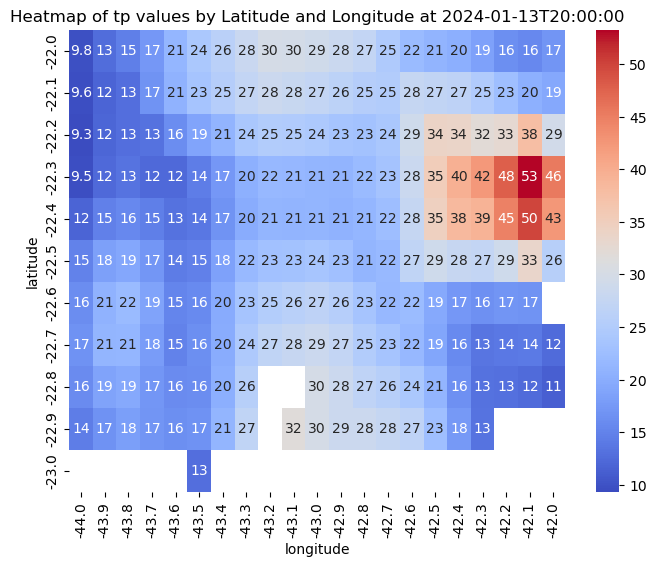

In [7]:
time_heat = "2024-01-13T20:00:00"
ds_day = cast(xr.Dataset, ds_day)
df_heat = ds_day.sel(time=f"{time_heat}").to_dataframe()[["tp"]] * 1000

df_unstacked = df_heat.unstack(level="longitude")
plt.figure(figsize=(8, 6))
sns.heatmap(df_unstacked["tp"], annot=True, cmap="coolwarm", cbar=True)
plt.title(f"Heatmap of tp values by Latitude and Longitude at {time_heat}")
# save the plot as an image
plt.savefig(f"heatmap_tp_values_{time_heat}.png")
plt.show()


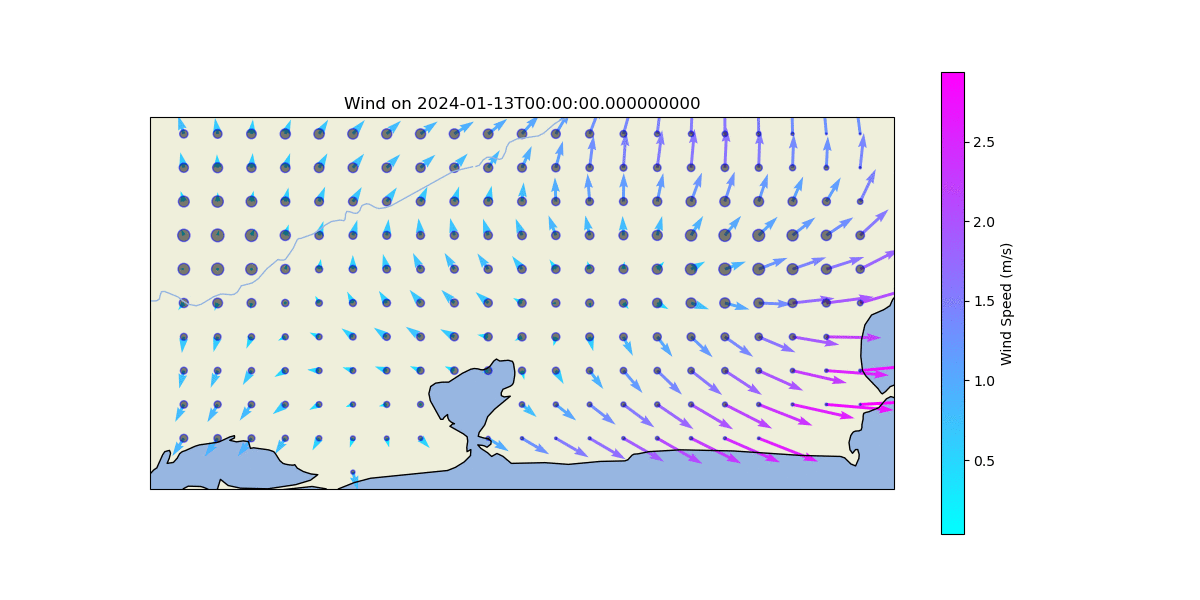

In [8]:
for gif in gif_files:
    display(Image(filename=gif))

In [9]:
ARBITRARY_HOUR = 12

if ds_day is not None:
    print(len(ds_day.time.values))
    u10_missing_values = ds_day["u10"].isnull().sum().values
    print(f"Variable u10 has {u10_missing_values} missing values")
    ds_arbitrary_hour = ds_day.sel(time=f"{day}T{ARBITRARY_HOUR:02d}:00:00")
    print(ds_arbitrary_hour)

24
Variable u10 has 648 missing values
<xarray.Dataset> Size: 8kB
Dimensions:    (latitude: 11, longitude: 21)
Coordinates:
  * longitude  (longitude) float32 84B -44.0 -43.9 -43.8 ... -42.2 -42.1 -42.0
  * latitude   (latitude) float32 44B -22.0 -22.1 -22.2 ... -22.8 -22.9 -23.0
    time       datetime64[ns] 8B 2024-01-13T12:00:00
Data variables:
    u10        (latitude, longitude) float64 2kB 0.124 0.2645 0.2656 ... nan nan
    v10        (latitude, longitude) float64 2kB 0.2707 0.3147 ... nan nan
    tp         (latitude, longitude) float64 2kB 0.0005485 0.0005728 ... nan nan
    speed10    (latitude, longitude) float64 2kB 0.2977 0.411 0.3826 ... nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-01 08:37:28 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


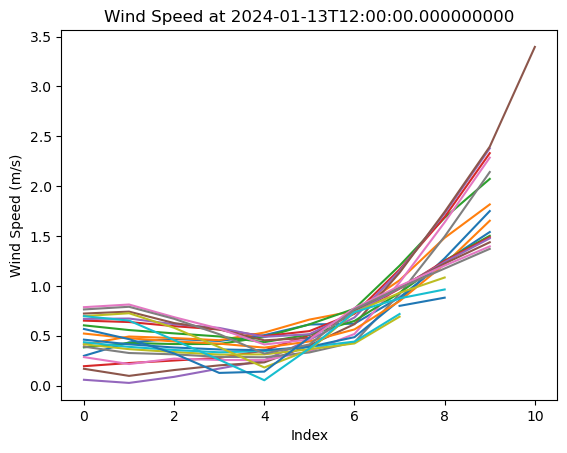

In [10]:
plt.plot(range(len(ds_arbitrary_hour["speed10"].values)), ds_arbitrary_hour["speed10"].values)
plt.xlabel("Index")
plt.ylabel("Wind Speed (m/s)")
plt.title(f"Wind Speed at {str(ds_arbitrary_hour.time.values)}")
plt.show()

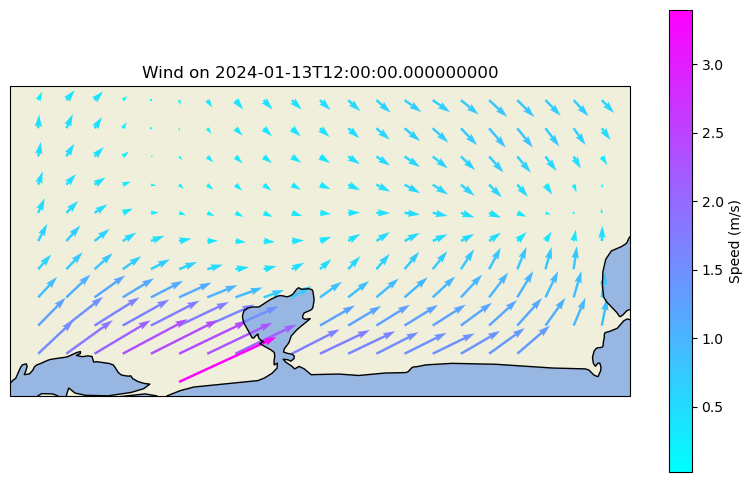

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
quiver = ax.quiver(
    ds_arbitrary_hour["longitude"].values,
    ds_arbitrary_hour["latitude"].values,
    ds_arbitrary_hour["u10"].values,
    ds_arbitrary_hour["v10"].values,
    ds_arbitrary_hour["speed10"].values,
    cmap="cool",
)
ax.set_title(f"Wind on {str(ds_arbitrary_hour.time.values)}")
fig.colorbar(quiver, ax=ax, label="Speed (m/s)")
plt.show()

In [12]:
fig, ax = plt.subplots()

time_values = np.linspace(0, 3, 40)

initial_velocity_1 = 12
initial_velocity_2 = 10


def s_v0t_plus_half_at2(v0, t):
    gravity = -9.81
    return v0 * t + (gravity * t**2) / 2


position_1, position_2 = (
    s_v0t_plus_half_at2(initial_velocity_1, time_values),
    s_v0t_plus_half_at2(initial_velocity_2, time_values),
)


scatter_plot = ax.scatter(
    time_values[0],
    position_1[0],
    c="blue",
    s=5,
    label=f"v0 = {initial_velocity_1} m/s",
)
line_plot = ax.plot(time_values[0], position_2[0], label=f"v0 = {initial_velocity_2} m/s")[0]

ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel="Time [s]", ylabel="Z [m]")
ax.legend()


def update(frame):
    current_time = time_values[:frame]

    scatter_plot.set_offsets(np.stack([current_time, position_1[:frame]]).T)

    line_plot.set_xdata(current_time)
    line_plot.set_ydata(position_2[:frame])

    return scatter_plot, line_plot


animation_obj = animation.FuncAnimation(fig=fig, func=update, frames=len(time_values), interval=30)
animation_obj.save("projectile_motion.gif", writer="imagemagick", fps=10)
plt.clf()

<Figure size 640x480 with 0 Axes>

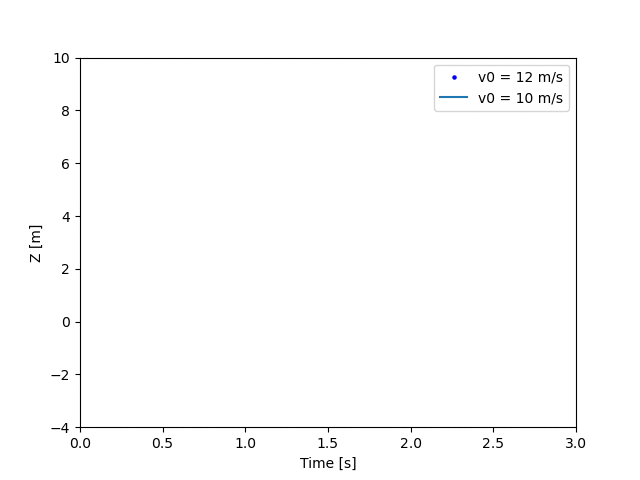

In [13]:
display(Image(filename="projectile_motion.gif"))

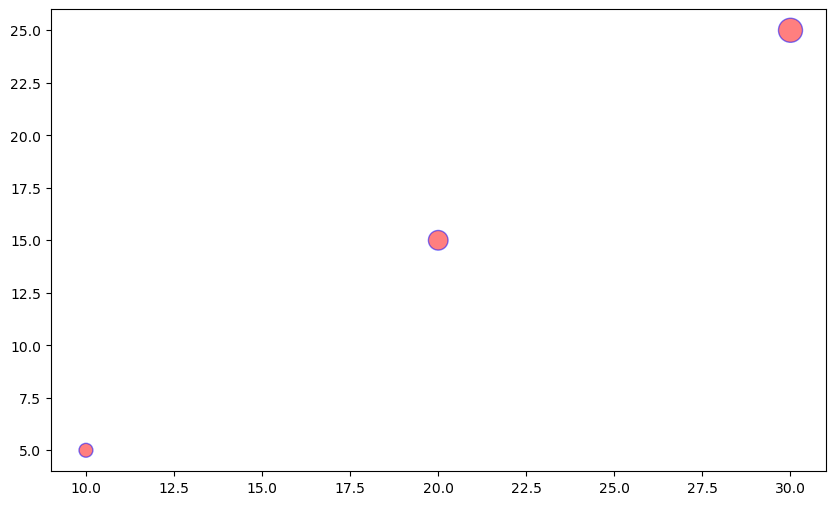

In [14]:
df = pd.DataFrame(
    {
        "longitude": [10, 20, 30],
        "latitude": [5, 15, 25],
        "precipitation": [1, 2, 3],
    }
)

fig, ax = plt.subplots(figsize=(10, 6))
scatter = plt.scatter(
    df["longitude"],
    df["latitude"],
    s=df["precipitation"] * 100,
    alpha=0.5,
    edgecolors="blue",
    c="red",
)
plt.show()

latitude=15, longitude=20 value: 4
np.tile(lon, lat.size)=[10 20 10 20 10 20]
np.repeat(lat, lon.size)=[ 5  5 15 15 25 25]
tp.flatten()=[1 2 3 4 5 6]


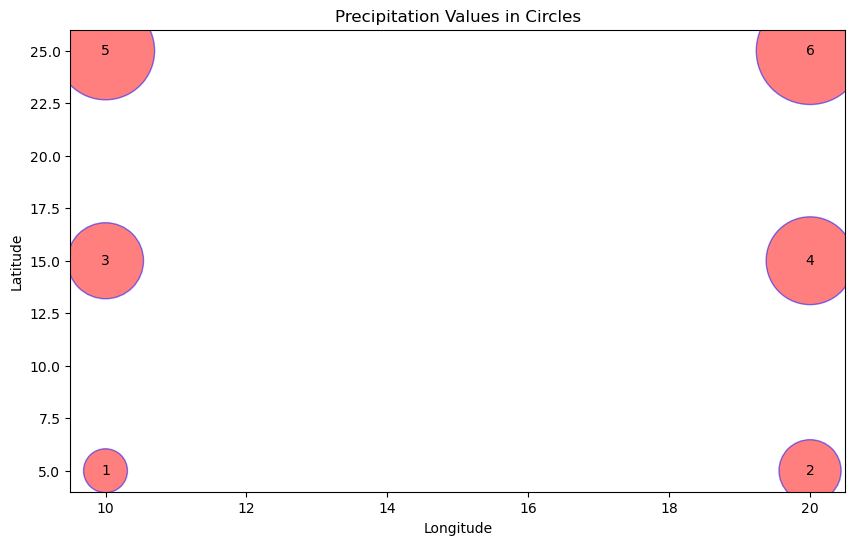

In [15]:
data = xr.DataArray(
    np.array([[1, 2], [3, 4], [5, 6]]),
    dims=("latitude", "longitude"),
    coords={"latitude": [5, 15, 25], "longitude": [10, 20]},
)
print(f"latitude=15, longitude=20 value: {data.sel(latitude=15, longitude=20).values}")

ds = xr.Dataset(
    {"tp": (["latitude", "longitude"], np.array([[1, 2], [3, 4], [5, 6]]))},
    coords={"latitude": np.array([5, 15, 25]), "longitude": np.array([10, 20])},
)

lon = ds["longitude"].values
lat = ds["latitude"].values
tp = ds["tp"].values

fig, ax = plt.subplots(figsize=(10, 6))

print(f"np.tile(lon, lat.size)={np.tile(lon, lat.size)}")
print(f"np.repeat(lat, lon.size)={np.repeat(lat, lon.size)}")
print(f"tp.flatten()={tp.flatten()}")

scatter = ax.scatter(
    np.tile(lon, lat.size),
    np.repeat(lat, lon.size),
    s=tp.flatten() * 1000,
    alpha=0.5,
    edgecolors="blue",
    c="red",
)

for i, txt in enumerate(tp.flatten()):
    ax.text(
        np.tile(lon, lat.size)[i],
        np.repeat(lat, lon.size)[i],
        str(txt),
        color="black",
        ha="center",
        va="center",
    )
    if i == 3:
        assert (
            txt == data.sel(latitude=15, longitude=20).values
        ), "third tp should be lat15,lon=20 value"

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Precipitation Values in Circles")
plt.show()

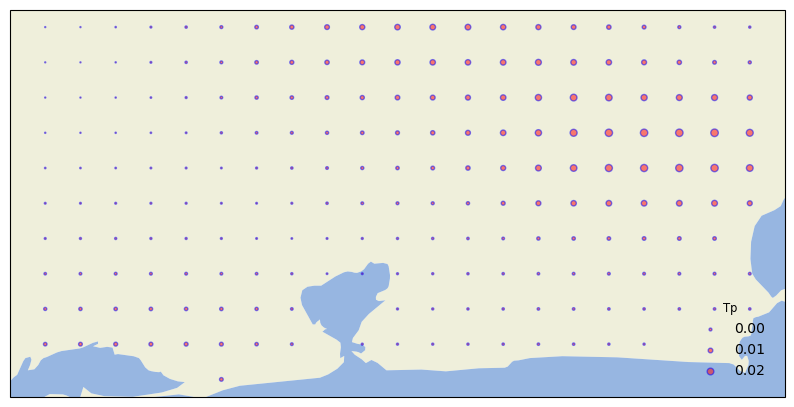

In [16]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

scatter = ax.scatter(
    np.tile(ds_arbitrary_hour["longitude"].values, ds_arbitrary_hour["latitude"].size),
    np.repeat(ds_arbitrary_hour["latitude"].values, ds_arbitrary_hour["longitude"].size),
    s=ds_arbitrary_hour["tp"].values.flatten() * 1000,
    alpha=0.5,
    edgecolors="blue",
    c="red",
)

precipitation_values = ds_arbitrary_hour["tp"].values.flatten()
percentiles = np.nanpercentile(precipitation_values, [50, 75, 95])
sizes = percentiles * 1000
labels = [f"{percentile:.2f}" for percentile in percentiles]

legend_patches = [
    plt.scatter([], [], s=size, edgecolors="blue", facecolors="red", alpha=0.5, label=label)
    for size, label in zip(sizes, labels)
]

ax.legend(
    handles=legend_patches,
    title="Tp",
    loc="lower right",
    # bbox_to_anchor=(0, 0),
    title_fontsize="small",
    borderpad=0.9,
    framealpha=0,
)
leg = ax.get_legend()
leg.set_alpha(0)

# plt.subplots_adjust(right=1)

plt.show()

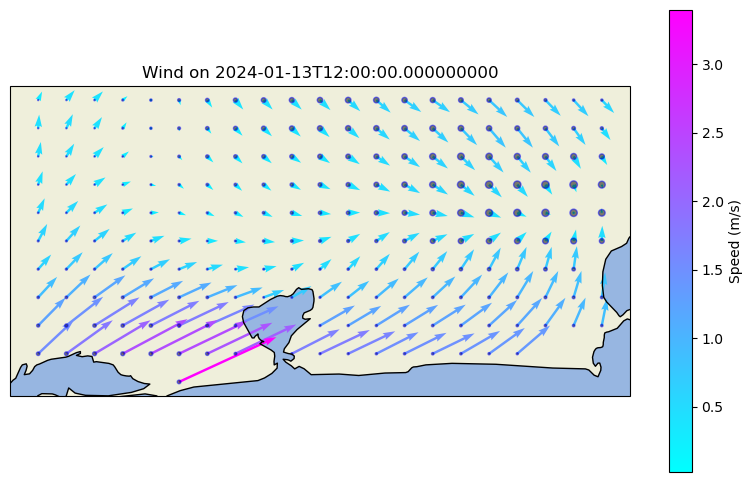

In [17]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_title(f"Wind on {str(ds_arbitrary_hour.time.values)}")
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

quiver = ax.quiver(
    ds_arbitrary_hour["longitude"].values,
    ds_arbitrary_hour["latitude"].values,
    ds_arbitrary_hour["u10"].values,
    ds_arbitrary_hour["v10"].values,
    ds_arbitrary_hour["speed10"].values,
    cmap="cool",
)

fig.colorbar(quiver, ax=ax, label="Speed (m/s)")

scatter = ax.scatter(
    np.tile(ds_arbitrary_hour["longitude"].values, ds_arbitrary_hour["latitude"].size),
    np.repeat(ds_arbitrary_hour["latitude"].values, ds_arbitrary_hour["longitude"].size),
    s=ds_arbitrary_hour["tp"].values.flatten() * 1000,
    alpha=0.5,
    edgecolors="blue",
    c="black",
)

precipitation_values = ds_arbitrary_hour["tp"].values.flatten()
percentiles = np.nanpercentile(precipitation_values, [50, 75, 95])
sizes = percentiles * 1000
labels = [f"{percentile:.2f}" for percentile in percentiles]

legend_patches = [
    plt.scatter([], [], s=size, edgecolors="blue", facecolors="black", alpha=0.5, label=label)
    for size, label in zip(sizes, labels)
]

# ax.legend(
#     handles=legend_patches,
#     title="Tp",
#     loc="lower right",
#     bbox_to_anchor=(0, 0),
#     title_fontsize="small",
#     borderpad=0.9,
#     framealpha=0,
# )

# plt.subplots_adjust(right=1)

plt.savefig(f"wind_and_precipitation_{ARBITRARY_HOUR}.png")

plt.show()